In [1]:
import sys
import os
import collections
import functools
import asyncio
import time
from pathlib import Path
import traceback

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import h5py
# import psycopg2
import sklearn

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)
from scipy.interpolate import interp1d, UnivariateSpline
from sklearn.model_selection import StratifiedKFold

In [4]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [5]:
from multiprocessing import Pool
from functools import partial
from tqdm.autonotebook import tqdm

c:\users\chris\.virtualenvs\sepsis-ml-mltipoic\lib\site-packages\ipykernel_launcher.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

In [7]:
def compute_prediction_utility(labels, predictions, dt_early=-12, dt_optimal=-6, dt_late=3.0, max_u_tp=1, min_u_fn=-2, u_fp=-0.05, u_tn=0, check_errors=True):
    max_u_tp = 1
    min_u_fn = -2
    u_fp     = -0.05
    u_tn     = 0
    # Check inputs for errors.
    if check_errors:
        if len(predictions) != len(labels):
            raise Exception('Numbers of predictions and labels must be the same.')

        for label in labels:
            if not label in (0, 1):
                raise Exception('Labels must satisfy label == 0 or label == 1.')

        for prediction in predictions:
            if not prediction in (0, 1):
                raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

        if dt_early >= dt_optimal:
            raise Exception('The earliest beneficial time for predictions must be before the optimal time.')

        if dt_optimal >= dt_late:
            raise Exception('The optimal time for predictions must be before the latest beneficial time.')

    # Does the patient eventually have sepsis?
    if np.any(labels):
        is_septic = True
        t_sepsis = np.argmax(labels) - dt_optimal
    else:
        is_septic = False
        t_sepsis = float('inf')

    n = len(labels)

    # Define slopes and intercept points for utility functions of the form
    # u = m * t + b.
    m_1 = float(max_u_tp) / float(dt_optimal - dt_early)
    b_1 = -m_1 * dt_early
    m_2 = float(-max_u_tp) / float(dt_late - dt_optimal)
    b_2 = -m_2 * dt_late
    m_3 = float(min_u_fn) / float(dt_late - dt_optimal)
    b_3 = -m_3 * dt_optimal

    # Compare predicted and true conditions.
    u = np.zeros(n)
    for t in range(n):
        if t <= t_sepsis + dt_late:
            # TP
            if is_septic and predictions[t]:
                if t <= t_sepsis + dt_optimal:
                    u[t] = max(m_1 * (t - t_sepsis) + b_1, u_fp)
                elif t <= t_sepsis + dt_late:
                    u[t] = m_2 * (t - t_sepsis) + b_2
            # FP
            elif not is_septic and predictions[t]:
                u[t] = u_fp
            # FN
            elif is_septic and not predictions[t]:
                if t <= t_sepsis + dt_optimal:
                    u[t] = 0
                elif t <= t_sepsis + dt_late:
                    u[t] = m_3 * (t - t_sepsis) + b_3
            # TN
            elif not is_septic and not predictions[t]:
                u[t] = u_tn

    # Find total utility for patient.
    return np.sum(u)

In [8]:
def compute_accuracy_f_measure(labels, predictions, check_errors=True):
    # Check inputs for errors.
    if check_errors:
        if len(predictions) != len(labels):
            raise Exception('Numbers of predictions and labels must be the same.')

        for label in labels:
            if not label in (0, 1):
                raise Exception('Labels must satisfy label == 0 or label == 1.')

        for prediction in predictions:
            if not prediction in (0, 1):
                raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

    # Populate contingency table.
    n = len(labels)
    tp = 0
    fp = 0
    fn = 0
    tn = 0

    for i in range(n):
        if labels[i] and predictions[i]:
            tp += 1
        elif not labels[i] and predictions[i]:
            fp += 1
        elif labels[i] and not predictions[i]:
            fn += 1
        elif not labels[i] and not predictions[i]:
            tn += 1

    # Summarize contingency table.
    if tp + fp + fn + tn:
        accuracy = float(tp + tn) / float(tp + fp + fn + tn)
    else:
        accuracy = 1.0

    if 2 * tp + fp + fn:
        f_measure = float(2 * tp) / float(2 * tp + fp + fn)
    else:
        f_measure = 1.0

    return accuracy, f_measure

In [9]:
def compute_auc(labels, predictions, check_errors=True):
    # Check inputs for errors.
    if check_errors:
        if len(predictions) != len(labels):
            raise Exception('Numbers of predictions and labels must be the same.')

        for label in labels:
            if not label in (0, 1):
                raise Exception('Labels must satisfy label == 0 or label == 1.')

        for prediction in predictions:
            if not 0 <= prediction <= 1:
                warnings.warn('Predictions do not satisfy 0 <= prediction <= 1.')

    # Find prediction thresholds.
    thresholds = np.unique(predictions)[::-1]
    if thresholds[0] != 1:
        thresholds = np.insert(thresholds, 0, 1)
    if thresholds[-1] == 0:
        thresholds = thresholds[:-1]

    n = len(labels)
    m = len(thresholds)

    # Populate contingency table across prediction thresholds.
    tp = np.zeros(m)
    fp = np.zeros(m)
    fn = np.zeros(m)
    tn = np.zeros(m)

    # Find indices that sort the predicted probabilities from largest to
    # smallest.
    idx = np.argsort(predictions)[::-1]

    i = 0
    for j in range(m):
        # Initialize contingency table for j-th prediction threshold.
        if j == 0:
            tp[j] = 0
            fp[j] = 0
            fn[j] = np.sum(labels)
            tn[j] = n - fn[j]
        else:
            tp[j] = tp[j - 1]
            fp[j] = fp[j - 1]
            fn[j] = fn[j - 1]
            tn[j] = tn[j - 1]

        # Update contingency table for i-th largest predicted probability.
        while i < n and predictions[idx[i]] >= thresholds[j]:
            if labels[idx[i]]:
                tp[j] += 1
                fn[j] -= 1
            else:
                fp[j] += 1
                tn[j] -= 1
            i += 1

    # Summarize contingency table.
    tpr = np.zeros(m)
    tnr = np.zeros(m)
    ppv = np.zeros(m)
    npv = np.zeros(m)

    for j in range(m):
        if tp[j] + fn[j]:
            tpr[j] = tp[j] / (tp[j] + fn[j])
        else:
            tpr[j] = 1
        if fp[j] + tn[j]:
            tnr[j] = tn[j] / (fp[j] + tn[j])
        else:
            tnr[j] = 1
        if tp[j] + fp[j]:
            ppv[j] = tp[j] / (tp[j] + fp[j])
        else:
            ppv[j] = 1
        if fn[j] + tn[j]:
            npv[j] = tn[j] / (fn[j] + tn[j])
        else:
            npv[j] = 1

    # Compute AUROC as the area under a piecewise linear function with TPR /
    # sensitivity (x-axis) and TNR / specificity (y-axis) and AUPRC as the area
    # under a piecewise constant with TPR / recall (x-axis) and PPV / precision
    # (y-axis).
    auroc = 0
    auprc = 0
    for j in range(m-1):
        auroc += 0.5 * (tpr[j + 1] - tpr[j]) * (tnr[j + 1] + tnr[j])
        auprc += (tpr[j + 1] - tpr[j]) * ppv[j + 1]

    return auroc, auprc

In [10]:
def normalised_utility(y, preds, *args, **kwargs):
    num_rows          = len(y)
    observed_predictions = preds
    best_predictions     = np.zeros(num_rows)
    worst_predictions    = np.zeros(num_rows)
    inaction_predictions = np.zeros(num_rows)

    if np.any(y):
        t_sepsis = np.argmax(y) - dt_optimal
        best_predictions[max(0, t_sepsis + dt_early) : min(t_sepsis + dt_late + 1, num_rows)] = 1
    worst_predictions = 1 - best_predictions
    
    observed_utility = compute_prediction_utility(y, observed_predictions, **kwargs)
    best_utility     = compute_prediction_utility(y, best_predictions, **kwargs)
    worst_utility    = compute_prediction_utility(y, worst_predictions, **kwargs)
    inaction_utility = compute_prediction_utility(y, inaction_predictions, **kwargs)
    normalized_observed_utility = (observed_utility - inaction_utility) \
    / (best_utility - inaction_utility) if best_utility > 0 else 0
    return normalized_observed_utility

In [11]:
def get_normalised_utility_score(cohort_labels, cohort_predictions, cohort_probabilities,
                                 dt_early=-12, dt_optimal=-6, dt_late=3.0, max_u_tp=1,
                                 min_u_fn=-2, u_fp=-0.05, u_tn=0):
    
    num_files     = len(cohort_labels)

    labels        = np.concatenate(cohort_labels)
    predictions   = np.concatenate(cohort_predictions)
    probabilities = np.concatenate(cohort_probabilities)

    auroc, auprc        = compute_auc(labels, probabilities)
    accuracy, f_measure = compute_accuracy_f_measure(labels, predictions)
    
    # Compute utility.
    observed_utilities = np.zeros(num_files)
    best_utilities     = np.zeros(num_files)
    worst_utilities    = np.zeros(num_files)
    inaction_utilities = np.zeros(num_files)
    
    for k in range(num_files):
        labels = cohort_labels[k]
        num_rows          = len(labels)
        observed_predictions = cohort_predictions[k]
        best_predictions     = np.zeros(num_rows)
        worst_predictions    = np.zeros(num_rows)
        inaction_predictions = np.zeros(num_rows)

        if np.any(labels):
            t_sepsis = np.argmax(labels) - dt_optimal
            best_predictions[int(max(0, t_sepsis + dt_early)) : int(min(t_sepsis + dt_late + 1, num_rows))] = 1
        worst_predictions = 1 - best_predictions

        observed_utilities[k] = compute_prediction_utility(labels, observed_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        best_utilities[k]     = compute_prediction_utility(labels, best_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        worst_utilities[k]    = compute_prediction_utility(labels, worst_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        inaction_utilities[k] = compute_prediction_utility(labels, inaction_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)

    unnormalized_observed_utility = np.sum(observed_utilities)
    unnormalized_best_utility     = np.sum(best_utilities)
    unnormalized_worst_utility    = np.sum(worst_utilities)
    unnormalized_inaction_utility = np.sum(inaction_utilities)

    normalized_observed_utility = (unnormalized_observed_utility - unnormalized_inaction_utility) / (unnormalized_best_utility - unnormalized_inaction_utility)
    return auroc, auprc, accuracy, f_measure, normalized_observed_utility

In [131]:
df = pd.read_csv('challenge/training/p000009.psv', sep='|')

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 41 columns):
HR                  23 non-null int64
O2Sat               23 non-null int64
Temp                21 non-null float64
SBP                 23 non-null int64
MAP                 23 non-null float64
DBP                 23 non-null int64
Resp                23 non-null int64
EtCO2               0 non-null float64
BaseExcess          4 non-null float64
HCO3                2 non-null float64
FiO2                7 non-null float64
pH                  4 non-null float64
PaCO2               4 non-null float64
SaO2                3 non-null float64
AST                 0 non-null float64
BUN                 2 non-null float64
Alkalinephos        0 non-null float64
Calcium             0 non-null float64
Chloride            3 non-null float64
Creatinine          2 non-null float64
Bilirubin_direct    0 non-null float64
Glucose             3 non-null float64
Lactate             1 non-null float64
Mag

In [127]:
df.head()

HR  O2Sat  Temp  SBP   MAP  DBP  Resp  EtCO2  BaseExcess  HCO3  ...  WBC  \
0  82    100  35.5  112  79.5   63    14    NaN         0.0  23.0  ...  8.7   
1  81    100  35.8  103  70.5   55    14    NaN         NaN   NaN  ...  NaN   
2  80    100  36.2  120  83.0   65    14    NaN         0.0   NaN  ...  NaN   
3  63    100  36.5   99  71.0   55    15    NaN         NaN   NaN  ...  NaN   
4  70     99  36.7  121  85.0   65    19    NaN        -3.0   NaN  ...  NaN   

   Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  ICULOS  \
0         NaN      115.0  76.71       0      0      1        -2.36       3   
1         NaN        NaN  76.71       0      0      1        -2.36       4   
2         NaN        NaN  76.71       0      0      1        -2.36       5   
3         NaN        NaN  76.71       0      0      1        -2.36       6   
4         NaN        NaN  76.71       0      0      1        -2.36       7   

   SepsisLabel  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 41 columns]

In [128]:
df.describe()

HR       O2Sat       Temp         SBP        MAP        DBP  \
count  23.000000   23.000000  21.000000   23.000000  23.000000  23.000000   
mean   77.043478   95.826087  36.880952  113.956522  73.608696  55.173913   
std     5.708672    2.757670   0.525946   10.182330   5.961918   4.696732   
min    63.000000   90.000000  35.500000   97.000000  63.000000  47.000000   
25%    73.500000   94.500000  36.800000  108.000000  70.750000  52.500000   
50%    79.000000   96.000000  37.000000  112.000000  72.000000  54.000000   
75%    81.000000   97.000000  37.100000  119.000000  78.000000  58.000000   
max    84.000000  100.000000  37.700000  137.000000  85.000000  65.000000   

            Resp  EtCO2  BaseExcess       HCO3  ...       WBC  Fibrinogen  \
count  23.000000    0.0        4.00   2.000000  ...  2.000000         0.0   
mean   18.652174    NaN       -0.75  24.000000  ...  9.300000         NaN   
std     3.549759    NaN        1.50   1.414214  ...  0.848528         NaN   
min    10.000000    NaN       -3.00  23.000000  ...  8.700000         NaN   
25%    17.000000    NaN       -0.75  23.500000  ...  9.000000         NaN   
50%    19.000000    NaN        0.00  24.000000  ...  9.300000         NaN   
75%    21.000000    NaN        0.00  24.500000  ...  9.600000         NaN   
max    23.000000    NaN        0.00  25.000000  ...  9.900000         NaN   

        Platelets           Age  Gender  Unit1  Unit2  HospAdmTime    ICULOS  \
count    2.000000  2.300000e+01    23.0   23.0   23.0        23.00  23.00000   
mean   111.000000  7.671000e+01     0.0    0.0    1.0        -2.36  14.00000   
std      5.656854  2.906048e-14     0.0    0.0    0.0         0.00   6.78233   
min    107.000000  7.671000e+01     0.0    0.0    1.0        -2.36   3.00000   
25%    109.000000  7.671000e+01     0.0    0.0    1.0        -2.36   8.50000   
50%    111.000000  7.671000e+01     0.0    0.0    1.0        -2.36  14.00000   
75%    113.000000  7.671000e+01     0.0    0.0    1.0        -2.36  19.50000   
max    115.000000  7.671000e+01     0.0    0.0    1.0        -2.36  25.00000   

       SepsisLabel  
count         23.0  
mean           0.0  
std            0.0  
min            0.0  
25%            0.0  
50%            0.0  
75%            0.0  
max            0.0  

[8 rows x 41 columns]

R^2 Score: 0.9844092131048964
Initial Kernel: 1**2 * RBF(length_scale=24) + WhiteKernel(noise_level=0.01)
Optimised: 316**2 * RBF(length_scale=24) + WhiteKernel(noise_level=300)
LML: -59.2771269457805


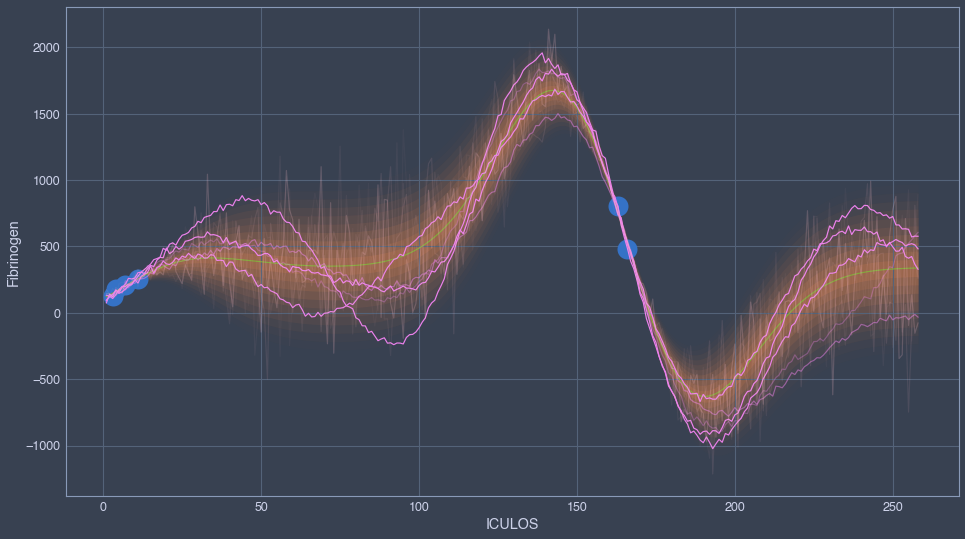

In [139]:
# --GPR + Kernel--
feature = 'Fibrinogen'
a_min   = -3000.0
a_max   = 3000.0
x = df[df[feature].isna() == False]['ICULOS']
kernel = 1.0 * RBF(length_scale=24, length_scale_bounds=(2.4e1, 1e3)) \
    + WhiteKernel(noise_level=1e-2, noise_level_bounds=(5e-2, 3e2))
gpr = GaussianProcessRegressor(
    kernel=kernel,
    random_state=42,
    alpha=3e-1,
    n_restarts_optimizer=5,
    normalize_y=True
).fit(x.to_numpy().reshape(-1, 1), df.iloc[x.index][feature])
print("R^2 Score: %s\nInitial Kernel: %s\nOptimised: %s\nLML: %s" % (
        gpr.score(x.to_numpy().reshape(-1, 1), df.iloc[x.index][feature]),
        kernel,
        gpr.kernel_,
        gpr.log_marginal_likelihood(gpr.kernel_.theta)
    )
)
# Predictions
x_pred = np.linspace(df['ICULOS'].iloc[0], df['ICULOS'].iloc[-1], 1e4).reshape(-1, 1)
y_pred, y_std = gpr.predict(x_pred, return_std=True)
# --Plotting--
fig, ax = plt.subplots(figsize=(16, 9))
# Raw Data
ax.plot('ICULOS', feature, 'bo', data=df.iloc[x.index], markersize=20)
# Predicted Values
ax.plot(
    x_pred,
    y_pred,
    'g-',
    label='Predicted Function'
)
# Interpolated Values (COV)
x_pred = np.array(df['ICULOS']).reshape(-1, 1)
for i, y_pred in enumerate(gpr.sample_y(x_pred, 5, 42).T):
    ax.plot(
        x_pred.flatten(),
        np.clip(y_pred, a_min, a_max),
        alpha=1/(i+1)*10,
        c='violet'
    )
# Interpolated Values (STD)
for i in range(5):
    y_pred, y_std = gpr.predict(x_pred, return_std=True)
    y_pred = np.random.normal(y_pred, y_std)
    ax.plot(
        x_pred.flatten(),
        np.clip(y_pred, a_min, a_max),
        alpha=1/(i+1)/5,
        c='pink'
    )

# Confidence Interval
y_pred, y_std = gpr.predict(x_pred, return_std=True)
for i in range(10):
    ax.fill_between(
        x_pred.flatten(),
        y_pred - .2*y_std*(i+1), y_pred + .2*y_std*(i+1),
        alpha=0.125 * (10-i)/10,
        label='Confidence interval',
        color='y'
    )
    
# Threshold
# sns.lineplot(np.array([x.iloc[0]-10, x.iloc[-1]+10]).astype('datetime64[s]'), y=[90, 90], ax=ax)
# ax.legend(['Raw Data', 'GPR Prediction', 'GPR Interpolation', 'GPR CI'])
ax.set_xlabel('ICULOS')
ax.set_ylabel(feature)
if 'CI' not in os.environ:
    # skip in continous integration
    plt.show()

In [46]:
gpr.kernel_.get_params()

{'k1': 0.709**2 * RBF(length_scale=51.3),
 'k2': WhiteKernel(noise_level=1e-05),
 'k1__k1': 0.709**2,
 'k1__k2': RBF(length_scale=51.3),
 'k1__k1__constant_value': 0.5021964184701134,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2__length_scale': 51.34839797751682,
 'k1__k2__length_scale_bounds': (24.0, 1000.0),
 'k2__noise_level': 9.999999999999997e-06,
 'k2__noise_level_bounds': (1e-05, 300.0)}

In [136]:
for col in df.columns:
    print(col)
    if df[col].isna().all():
        df[col] = [0]*len(df)
        df['%s_std' % (col)] = [0]*len(df)
    elif col != 'ICULOS':
        x = df[df[col].isna() == False]['ICULOS']
        kernel = 1.0 * Matern(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) \
        + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-5, 1e-1))
        gpr = GaussianProcessRegressor(
            kernel=kernel,
            random_state=42,
            n_restarts_optimizer=50
        ).fit(x.to_numpy().reshape(-1, 1), df.iloc[x.index][col])
        x_pred = np.array(df['ICULOS']).reshape(-1, 1)
        y_pred, y_std = gpr.predict(x_pred, return_std=True)
        df[col] = y_pred
        df['%s_std' % (col)] = y_std

HR
O2Sat
Temp
SBP
MAP
DBP
Resp
EtCO2
BaseExcess
HCO3
FiO2
pH
PaCO2
SaO2
AST
BUN
Alkalinephos
Calcium
Chloride
Creatinine
Bilirubin_direct
Glucose
Lactate
Magnesium
Phosphate
Potassium
Bilirubin_total
TroponinI
Hct
Hgb
PTT
WBC
Fibrinogen
Platelets
Age


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.68773346e-04, -2.63651625e+01,  1.75830156e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.35591254e-05, -2.63650622e+01,  1.75830501e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.59848481e-04, -2.63651576e+01,  1.75830173e+01]), 'task

Gender
Unit1
Unit2
HospAdmTime
ICULOS
SepsisLabel


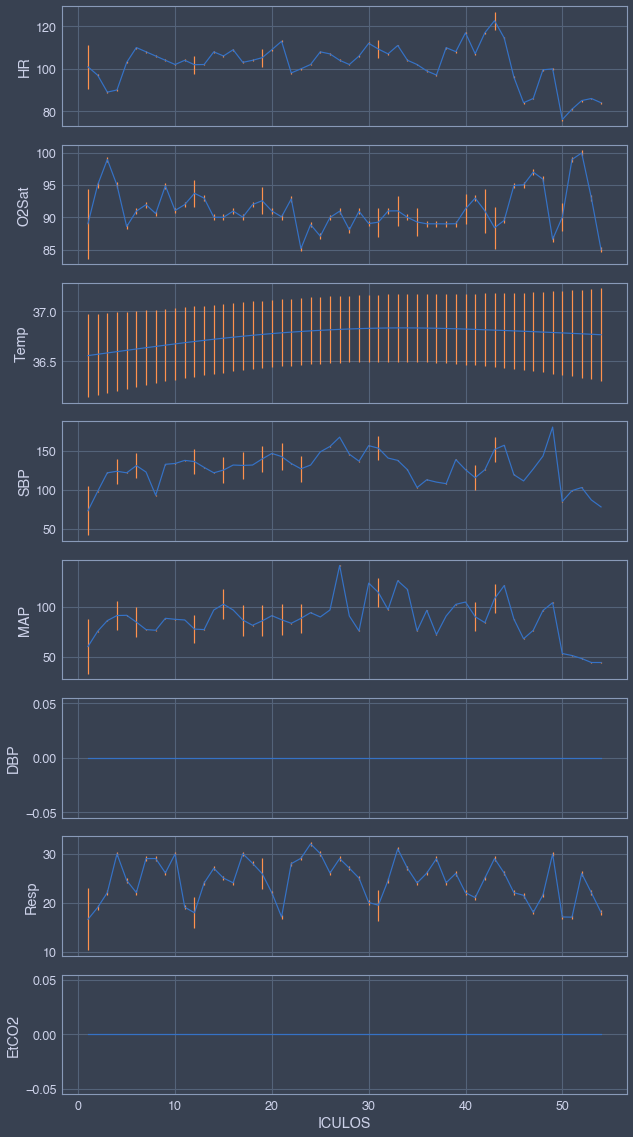

In [137]:
fig, ax = plt.subplots(8, 1, figsize=(9, 16), sharex=True)
for idx, measurement in enumerate(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']):
    ax[idx].errorbar(
        df['ICULOS'],
        df[measurement], df['%s_std' % (measurement)],
        ecolor='y'
    )
    ax[idx].set_ylabel(measurement)

plt.xlabel('ICULOS')
plt.tight_layout()

In [139]:
df.to_csv('challenge/interpolated/training/p000001.psv')

In [145]:
df.columns[34:]

Index(['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS',
       'SepsisLabel', 'HR_std', 'O2Sat_std', 'Temp_std', 'SBP_std', 'MAP_std',
       'DBP_std', 'Resp_std', 'EtCO2_std', 'BaseExcess_std', 'HCO3_std',
       'FiO2_std', 'pH_std', 'PaCO2_std', 'SaO2_std', 'AST_std', 'BUN_std',
       'Alkalinephos_std', 'Calcium_std'],
      dtype='object')

In [223]:
df[[col for col in df.columns if col not in ['Unnamed: 0.1', 'Unit1_std', 'Unit2_std']]]

HR      O2Sat       Temp         SBP         MAP  DBP       Resp  \
0   100.919716  89.020462  36.556740   73.036462   59.985798    0  16.569312   
1    96.991489  95.015888  36.570080   98.000957   75.329549    0  18.987363   
2    89.004819  98.973644  36.583357  121.997737   85.999602    0  22.038370   
3    90.014268  94.976352  36.596570  123.991060   91.102407    0  29.947416   
4   102.988940  88.565287  36.609718  122.001678   91.329127    0  24.515706   
5   109.993435  90.970414  36.622803  131.248800   84.508421    0  22.027241   
6   108.006854  91.963648  36.635822  122.992554   76.999383    0  28.973554   
7   105.999420  90.587725  36.648763   93.013188   76.332452    0  28.985545   
8   103.994956  94.895759  36.661555  132.988949   88.326528    0  26.053518   
9   102.011144  91.071132  36.674115  134.004934   87.332070    0  29.924388   
10  103.988589  91.980914  36.686359  137.998188   86.667821    0  19.047332   
11  101.918754  93.731253  36.698216  136.496564   77.498343    0  17.910973   
12  102.017287  92.982928  36.709666  128.999484   77.003008    0  23.991536   
13  107.972130  90.020436  36.720703  122.000776   96.666964    0  26.993043   
14  106.030329  90.004066  36.731319  125.513036  102.456503    0  24.993371   
15  108.968663  90.972149  36.741508  131.999002   96.669476    0  24.032270   
16  103.023912  90.032822  36.751257  131.516075   86.587944    0  29.962218   
17  103.988742  91.983483  36.760536  132.000472   81.330569    0  28.016931   
18  105.229204  92.583605  36.769309  139.879068   85.740746    0  25.892811   
19  109.022279  90.979118  36.777540  146.998960   90.998552    0  21.966321   
20  112.948674  90.083174  36.785202  142.944508   86.890072    0  17.070430   
21   98.051474  92.851874  36.792304  133.999727   83.330625    0  27.933044   
22   99.970156  85.161689  36.798862  127.158972   88.282628    0  29.038175   
23  102.020055  88.875136  36.804892  132.001640   93.998758    0  31.980726   
24  107.983864  87.076734  36.810410  148.996796   89.666819    0  29.989376   
25  107.005816  89.979840  36.815413  156.004045   96.683306    0  26.031575   
26  103.996139  90.957982  36.819898  167.994510  141.310195    0  28.968824   
27  102.004893  88.076288  36.823859  146.001675   90.677876    0  27.018505   
28  106.006032  90.930193  36.827284  137.003424   75.678811    0  24.980760   
29  111.986345  89.035287  36.830125  156.996026  123.658408    0  20.011514   
30  109.277489  89.250568  36.832327  153.765566  114.273043    0  19.460641   
31  107.021139  90.990339  36.833834  141.001534   97.008304    0  24.515266   
32  110.969372  91.012216  36.834605  137.999449  125.994582    0  30.965381   
33  104.021941  90.002722  36.834666  125.996650  117.322036    0  27.014175   
34  101.993852  89.282777  36.834056  103.005522   75.686473    0  24.002018   
35   98.983406  88.999909  36.832816  112.996370   96.312737    0  26.013488   
36   97.045155  89.001438  36.830994  109.998350   72.012673    0  28.958393   
37  109.939404  88.990606  36.828665  108.006913   90.663861    0  24.047611   
38  108.065558  89.014797  36.825915  138.991945  102.331812    0  25.960702   
39  116.927651  91.319391  36.822828  126.002921  104.667269    0  22.015536   
40  107.061353  92.985251  36.819487  115.651152   89.933327    0  21.003050   
41  116.975965  91.014229  36.815970  126.001265   84.003222    0  25.004280   
42  122.656361  88.383796  36.812343  152.119983  108.007926    0  28.982695   
43  114.489627  89.539311  36.808617  157.494301  121.163243    0  26.000183   
44   96.007820  94.939415  36.804795  119.504474   87.503475    0  22.016533   
45   84.001529  95.041089  36.800875  111.501116   67.831224    0  21.476294   
46   86.012260  97.011975  36.796859  126.994256   76.329109    0  18.008539   
47   99.502764  95.911110  36.792746  143.514932   96.173716    0  21.544225   
48   99.942212  86.590694  36.788537  180.972607  103.987312    0  29.907983   
49   76.0730

In [76]:
def GPR_saver(folder, file):
    if file.split('.')[-1] == 'psv':
        df = pd.read_csv(f'challenge/{folder}/{file}', sep='|')
#         print(f'{idx}/{files}: {file}', end='\r')
        covs = {}
        for col in df.columns:
            # Check if values are NaN
            if df[col].isna().all():
                df[col] = [0]*len(df)
                # Check column is a measurement (not demographic)
                if col in df.columns[:34]:
                    df['%s_std' % (col)] = [0]*len(df)
            # If values are not NaN and are measurements, perform GPR.
            elif col in df.columns[:34]:
                x = df[df[col].isna() == False]['ICULOS']
                kernel = 1.0 * RBF(length_scale=24, length_scale_bounds=(2.4e1, 1e3)) \
                    + WhiteKernel(noise_level=1e-2, noise_level_bounds=(5e-2, 3e1))
                gpr = GaussianProcessRegressor(
                    kernel=kernel,
                    random_state=42,
                    alpha=3e-1,
                    n_restarts_optimizer=5,
                    normalize_y=True
                ).fit(x.to_numpy().reshape(-1, 1), df.iloc[x.index][col])
                x_pred = np.array(df['ICULOS']).reshape(-1, 1)
                y_pred, y_std = gpr.predict(x_pred, return_std=True)
                df[col] = y_pred
                df['%s_std' % (col)] = y_std

        df.to_csv('challenge/interpolated/training_gpr/%s' % (file))

In [7]:
def GPR_saver_h5py(folder, file, overwrite=False):
    if file.split('.')[-1] == 'psv':
        df = pd.read_csv(f'challenge/{folder}/{file}', sep='|')
#         print(f'{idx}/{files}: {file}', end='\r')
        with h5py.File('challenge/interpolated/training_cov/%s.hdf5' % \
                       (file.split('.')[0]), 'r+') as f:
            for col in df.columns:
                if overwrite:
                    # Check if values are NaN
                    if df[col].isna().all():
                        f[col] = np.zeros(len(df))
                        # Check column is a measurement (not demographic)
                        if col in df.columns[:34]:
                            f['%s_cov' % (col)] = np.zeros((len(df), len(df)))
                    # If values are not NaN and are measurements, perform GPR.
                    elif col in df.columns[:34]:
                        x = df[df[col].isna() == False]['ICULOS']
                        kernel = 1.0 * RBF(length_scale=24, length_scale_bounds=(2.4e1, 1e3)) \
                            + WhiteKernel(noise_level=1e-2, noise_level_bounds=(5e-2, 3e1))
                        gpr = GaussianProcessRegressor(
                            kernel=kernel,
                            random_state=42,
                            alpha=3e-1,
                            n_restarts_optimizer=5,
                            normalize_y=True
                        ).fit(x.to_numpy().reshape(-1, 1), df.iloc[x.index][col])
                        x_pred = np.array(df['ICULOS']).reshape(-1, 1)
                        y_pred, y_cov = gpr.predict(x_pred, return_cov=True)
                        f[col] = y_pred
                        f['%s_cov' % (col)] = y_cov
                    else:
                        f[col] = df[col].to_numpy()
                elif col not in f.keys():
                    f[col] = df[col].to_numpy()

In [138]:
pd.read_csv('challenge/interpolated/training2.bak/p000001.psv', index_col=0)

HR      O2Sat       Temp         SBP         MAP  DBP       Resp  \
0   100.554878  91.477290  36.778000  115.699084   81.965665    0  23.221719   
1    96.994371  94.999984  36.778000   98.004483   75.331997    0  19.014853   
2    89.011050  98.999966  36.778000  121.998972   85.999416    0  22.009318   
3    90.015911  94.999984  36.778000  125.264228   89.427463    0  29.980387   
4   102.991730  88.500014  36.778000  122.000760   91.329301    0  24.503229   
5   109.989963  91.000002  36.778000  126.224437   85.504851    0  22.012085   
6   108.001123  91.999998  36.110176  122.998264   77.000997    0  28.987053   
7   105.998277  90.500004  36.778000   93.006644   76.331593    0  28.990445   
8   103.997075  94.999984  36.778000  132.996801   88.328983    0  26.005501   
9   102.006525  91.000002  36.778000  134.000253   87.330265    0  29.977224   
10  103.992763  91.999998  37.169897  137.998495   86.669843    0  19.023082   
11  102.208326  91.477283  36.778000  131.709768   82.082406    0  22.550829   
12  102.010853  92.999993  36.778000  128.999451   77.002485    0  24.003720   
13  107.981824  90.000007  36.778000  122.000965   96.667717    0  26.992287   
14  106.014082  90.000007  36.778000  126.636345   95.695568    0  25.000089   
15  108.979743  91.000002  36.560057  131.999236   96.668701    0  24.007363   
16  103.013169  90.000007  36.778000  130.201781   88.261028    0  29.984442   
17  103.994575  91.999998  36.778000  131.999520   81.331066    0  27.994876   
18  105.301481  91.477273  36.778000  135.412908   86.341087    0  25.059238   
19  109.007389  91.000002  37.109913  146.997215   90.999287    0  22.001278   
20  112.964686  90.000007  36.778000  136.194258   87.180781    0  17.026841   
21   98.031739  92.999993  36.778000  133.999185   83.330744    0  27.984776   
22   99.987889  85.000030  36.778000  129.604135   88.275778    0  28.996370   
23  102.010162  89.000011  36.670028  132.000378   93.998915    0  31.983863   
24  107.987733  87.000020  36.778000  148.997605   89.669876    0  29.989335   
25  106.999633  90.000007  36.778000  155.998561   96.672778    0  26.003946   
26  103.998104  91.000002  36.778000  167.995107  141.319725    0  28.988144   
27  102.004862  88.000016  36.500073  145.999212   90.672250    0  26.997501   
28  106.002619  91.000002  36.778000  137.000865   75.674765    0  24.996326   
29  111.984886  89.000011  36.778000  156.995601  123.662625    0  20.014959   
30  108.723486  91.477259  36.778000  141.865938  104.348811    0  23.052340   
31  107.009267  91.000002  37.439826  140.998689   97.001536    0  24.505944   
32  110.978550  91.477263  36.778000  137.998951  125.995227    0  30.980863   
33  104.011213  90.000007  36.778000  125.999240  117.325531    0  26.997801   
34  101.996539  91.477254  36.778000  103.003626   75.675608    0  24.004531   
35   98.994312  89.000011  37.109913  113.000088   96.325144    0  25.999259   
36   97.028138  89.000011  36.778000  110.001076   72.004501    0  28.985857   
37  109.963988  89.000011  36.778000  108.003461   90.668697    0  24.008380   
38  108.031389  89.000011  36.778000  138.996469  102.328838    0  25.992229   
39  116.953976  91.477268  36.779999  126.001132  104.667897    0  22.007353   
40  107.037022  92.999993  36.778000  124.681669   91.306160    0  21.009676   
41  116.974398  91.477280  36.330118  126.000435   84.001241    0  24.999978   
42  118.903507  91.477263  36.778000  138.322124   99.515708    0  28.987882   
43  114.477891  89.500009  36.778000  157.494573  121.164162    0  25.997586   
44   96.010964  94.999984  36.778000  119.502370   87.501227    0  22.007925   
45   84.012599  94.999984  36.778000  111.501959   67.832551    0  21.502324   
46   86.016648  96.999975  36.778000  126.999388   76.331111    0  18.016348   
47   99.495118  95.999979  36.778000  143.501375   96.169500    0  21.511348   
48   99.963545  86.500023  36.778000  180.988012  103.994826    0  29.973220   
49   76.0546

In [26]:
GPR_saver_h5py('training', 'p000001.psv')

In [77]:
GPR_saver('training', 'p000001.psv')

In [8]:
for folder in tqdm(['training', 'training_setB'], desc='Training Folder'):
    files = len(os.listdir("challenge/%s/" % (folder)))
    with Pool() as p:
        r = list(tqdm(p.imap(
            partial(GPR_saver_h5py, folder),
            os.listdir(f'challenge/%s/' % (folder))
        ), total=files, desc='Files for GPR'))

In [268]:
np.vstack((f['HCO3'][()], f['HCO3_cov'][()]))[0], f['HCO3'][()]

(array([24.444043, 24.400596, 24.354377, 24.30548 , ..., 24.448656, 24.593094, 24.739716, 24.887901]),
 array([24.444043, 24.400596, 24.354377, 24.30548 , ..., 24.448656, 24.593094, 24.739716, 24.887901]))

In [266]:
np.array([np.vstack((f[k.split('_cov')[0]][()], f[k][()])) for k in f.keys() if '_cov' in k]).shape

(34, 259, 258)

In [278]:
np.vstack([f[k][()] for k in ['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel']]).shape

(7, 258)

In [332]:
cols = [k.split('_cov')[0] for k in f.keys() if '_cov' in k]
cols.sort(); cols

['AST',
 'Alkalinephos',
 'BUN',
 'BaseExcess',
 'Bilirubin_direct',
 'Bilirubin_total',
 'Calcium',
 'Chloride',
 'Creatinine',
 'DBP',
 'EtCO2',
 'FiO2',
 'Fibrinogen',
 'Glucose',
 'HCO3',
 'HR',
 'Hct',
 'Hgb',
 'Lactate',
 'MAP',
 'Magnesium',
 'O2Sat',
 'PTT',
 'PaCO2',
 'Phosphate',
 'Platelets',
 'Potassium',
 'Resp',
 'SBP',
 'SaO2',
 'Temp',
 'TroponinI',
 'WBC',
 'pH']

In [358]:
def h5py_to_np_struct(folder, fn):
    path = Path(fn)
    if path.suffix == '.hdf5':
        with h5py.File(folder+fn, 'r') as f:
            path = 'challenge/interpolated/training_cov_npy/' + path.name.split('.hdf5')[0] + '.npy'
            x = np.array([np.vstack((f[k.split('_cov')[0]][()], f[k][()])) for k in cols])
            l = x.shape[-1]
            others = ['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel']
            others = np.vstack([f[k][()] for k in others])
            others.resize(34, 1, l)
            x = np.concatenate([x, others], axis=1)
            mm = np.memmap(path, dtype='float64', mode='w+', shape=x.shape)
            mm[:] = x[:]
            mm.flush()
            return mm

In [359]:
h5py_to_np_struct('challenge/interpolated/training_cov/', 'p000009.hdf5')

memmap([[[ 0.      ,  0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ,  0.      ],
         [ 0.      ,  0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ,  0.      ],
         [27.92    , 27.92    , 27.92    , 27.92    , ..., 27.92    , 27.92    , 27.92    , 27.92    ]],

        [[ 0.      ,  0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ,  0.      ],
         [ 0.      ,  0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ,  0.      ],
         [ 1.      ,  1.      ,  1.      ,  1.      , ...,  1.      ,  1.      ,  1.      ,  1.      ]],

        [[11.269221, 11.289377, 11.314638, 11.344911, ..., 21.849347, 21.76274 , 21.676759, 21.591546],
         [11.269221, 11.289377, 11.314638, 11.344911, ..., 21.849347, 21.76274 , 21.676759, 21.591546],
         [ 0.      ,  0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ,  0.      ]],

        [[-2.27375 , -2.286667, -2.29727 , -2.305539, ...,

In [360]:
files = len(os.listdir("challenge/interpolated/training_cov"))
with Pool() as p:
    r = list(tqdm(p.imap(
        partial(h5py_to_np_struct, 'challenge/interpolated/training_cov/'),
        os.listdir("challenge/interpolated/training_cov")
    ), total=files, desc='.npy Files for GPR'))

In [324]:
max_length = ['NaN', 0]
for file in tqdm(os.listdir('challenge/training/')):
    if file.split('.')[-1] == 'psv':
        df = pd.read_csv(f'challenge/training/{file}', index_col=0, sep='|')
        if len(df) > max_length[1]:
            max_length[1] = len(df)
            max_length[0] = file
print(max_length)


['p003658.psv', 336]


In [224]:
files = len(os.listdir("challenge/interpolated/training/"))
for idx, file in enumerate(tqdm(os.listdir('challenge/interpolated/training/'))):
    if file.split('.')[-1] == 'psv':
        df = pd.read_csv(f'challenge/interpolated/training/{file}', index_col=0)
        df = df[[col for col in df.columns if col not in ['Unnamed: 0.1', 'Unit1_std', 'Unit2_std']]]
        df.to_csv('challenge/interpolated/training/%s' % (file))

In [12]:
df = pd.read_csv('challenge/interpolated/training_gpr/p000009.psv', index_col=0)

In [13]:
df.head()

HR      O2Sat       Temp         SBP        MAP        DBP  \
0  114.821515  96.002471  36.099684  102.311800  78.040608  62.190449   
1  113.830780  95.944782  36.115212  102.307616  77.719324  62.036159   
2  112.809965  95.892597  36.134394  102.380329  77.409880  61.898949   
3  111.764218  95.846347  36.157128  102.527477  77.112681  61.778197   
4  110.698969  95.806423  36.183284  102.745690  76.827879  61.672961   

        Resp  EtCO2  BaseExcess       HCO3  ...  Phosphate_std  Potassium_std  \
0  23.715731      0   -2.273750  24.444043  ...       0.564831       0.004472   
1  23.658059      0   -2.286667  24.400596  ...       0.556339       0.004472   
2  23.600529      0   -2.297270  24.354377  ...       0.548230       0.004472   
3  23.543445      0   -2.305539  24.305480  ...       0.540553       0.004472   
4  23.487109      0   -2.311445  24.254055  ...       0.533357       0.004472   

   Bilirubin_total_std  TroponinI_std   Hct_std   Hgb_std   PTT_std   WBC_std  \
0                    0              0  3.208585  0.918595  3.028679  2.416833   
1                    0              0  3.189273  0.907953  2.968648  2.402280   
2                    0              0  3.172416  0.899236  2.918557  2.389630   
3                    0              0  3.158020  0.892414  2.878317  2.378862   
4                    0              0  3.146061  0.887423  2.847640  2.369932   

   Fibrinogen_std  Platelets_std  
0       10.599024       8.950120  
1        8.337427       7.656383  
2        6.976798       6.820025  
3        6.454057       6.413531  
4        6.472288       6.347727  

[5 rows x 75 columns]

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258 entries, 0 to 257
Data columns (total 75 columns):
HR                      258 non-null float64
O2Sat                   258 non-null float64
Temp                    258 non-null float64
SBP                     258 non-null float64
MAP                     258 non-null float64
DBP                     258 non-null float64
Resp                    258 non-null float64
EtCO2                   258 non-null int64
BaseExcess              258 non-null float64
HCO3                    258 non-null float64
FiO2                    258 non-null float64
pH                      258 non-null float64
PaCO2                   258 non-null float64
SaO2                    258 non-null float64
AST                     258 non-null int64
BUN                     258 non-null float64
Alkalinephos            258 non-null int64
Calcium                 258 non-null float64
Chloride                258 non-null float64
Creatinine              258 non-null float64
B

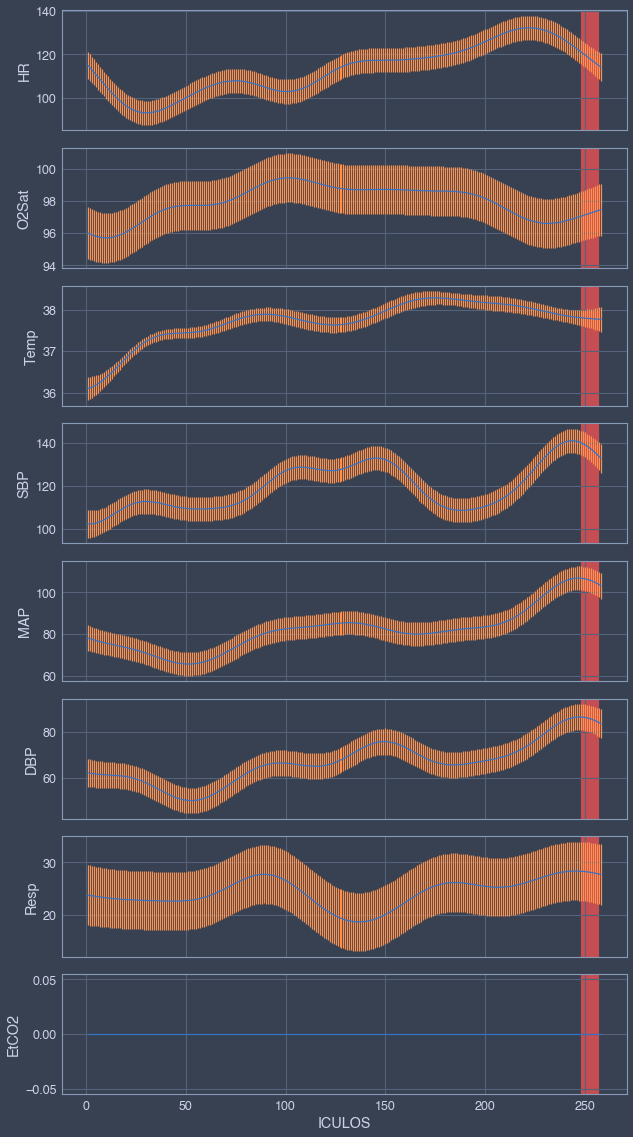

In [14]:
fig, ax = plt.subplots(8, 1, figsize=(9, 16), sharex=True)
for idx, measurement in enumerate(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']):
    ax[idx].errorbar(
        df['ICULOS'],
        df[measurement], df['%s_std' % (measurement)],
        ecolor='y'
    )
    ax[idx].set_ylabel(measurement)
    ax[idx].axvspan(
        df[df['SepsisLabel'] == 1].iloc[0].name,
        df[df['SepsisLabel'] == 1].iloc[-1].name,
        color='r'
    )
plt.xlabel('ICULOS')
plt.tight_layout()

In [138]:
df['SepsisLabel']

0      0
1      0
2      0
3      0
4      0
      ..
253    1
254    1
255    1
256    1
257    1
Name: SepsisLabel, Length: 258, dtype: int64

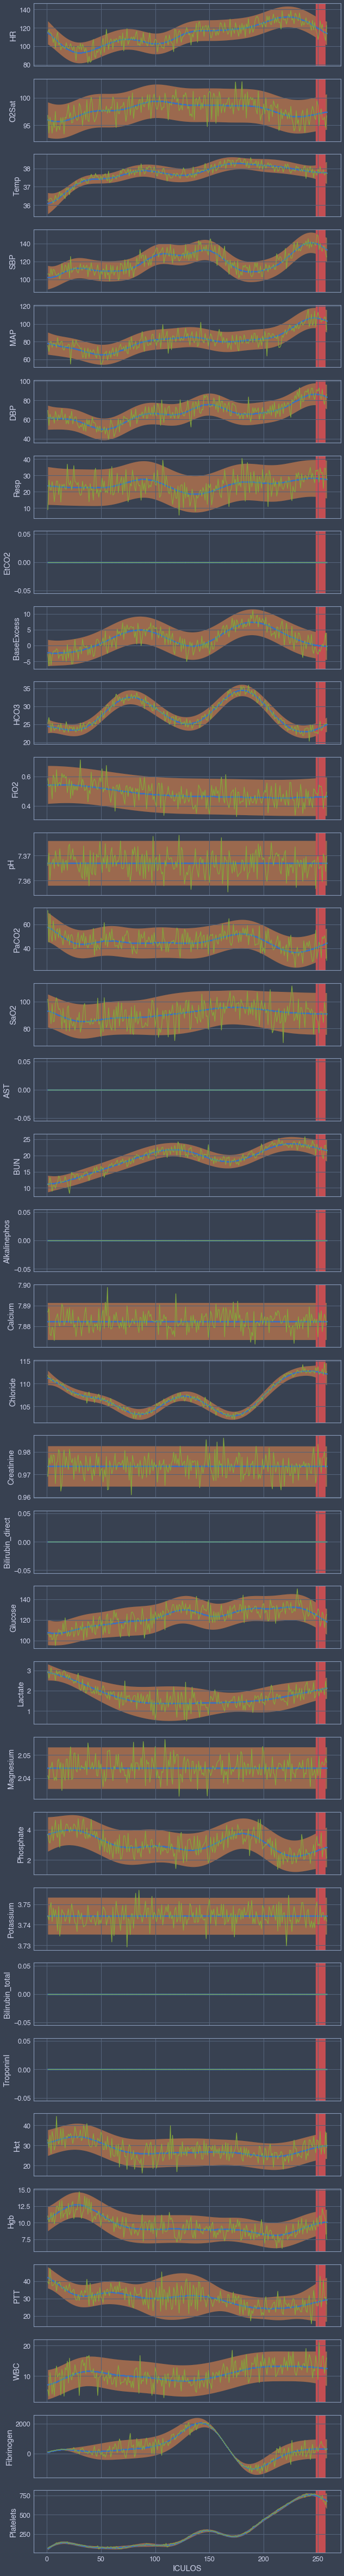

In [16]:
fig, ax = plt.subplots(34, 1, figsize=(9, 66), sharex=True)
for idx, measurement in enumerate(df.columns[:34]):
#     ax[idx].errorbar(
#         df['ICULOS'],
#         df[measurement], df['%s_std' % (measurement)],
#         ecolor='y'
#     )
    ax[idx].plot(
        df['ICULOS'],
        df[measurement],
        'b.'
    )
    ax[idx].fill_between(
        df['ICULOS'],
        df[measurement] - 2 * df[f'{measurement}_std'],
        df[measurement] + 2 * df[f'{measurement}_std'],
        alpha=0.5,
        color='y'
    )
    ax[idx].plot(
        df['ICULOS'],
        np.random.normal(df[measurement], df['%s_std' % (measurement)], len(df)),
        'g-'
    )
    ax[idx].set_ylabel(measurement)
    ax[idx].axvspan(
        df[df['SepsisLabel'] == 1].iloc[0].name,
        df[df['SepsisLabel'] == 1].iloc[-1].name,
        color='r'
    )
plt.xlabel('ICULOS')
plt.tight_layout()

In [39]:
f = h5py.File('challenge/interpolated/training_cov/p000009.hdf5', mode='r')

In [43]:
[key for key in f.keys() if 'cov' not in key and key not in ['Age', 'Gender', 'Unit1', 'Unit2', 'ICULOS', 'HospAdmTime', 'SepsisLabel']]

['AST',
 'Alkalinephos',
 'BUN',
 'BaseExcess',
 'Bilirubin_direct',
 'Bilirubin_total',
 'Calcium',
 'Chloride',
 'Creatinine',
 'DBP',
 'EtCO2',
 'FiO2',
 'Fibrinogen',
 'Glucose',
 'HCO3',
 'HR',
 'Hct',
 'Hgb',
 'Lactate',
 'MAP',
 'Magnesium',
 'O2Sat',
 'PTT',
 'PaCO2',
 'Phosphate',
 'Platelets',
 'Potassium',
 'Resp',
 'SBP',
 'SaO2',
 'Temp',
 'TroponinI',
 'WBC',
 'pH']

In [29]:
np.where(f['SepsisLabel'].value == 1)[0]

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """Entry point for launching an IPython kernel.


array([248, 249, 250, 251, 252, 253, 254, 255, 256, 257])

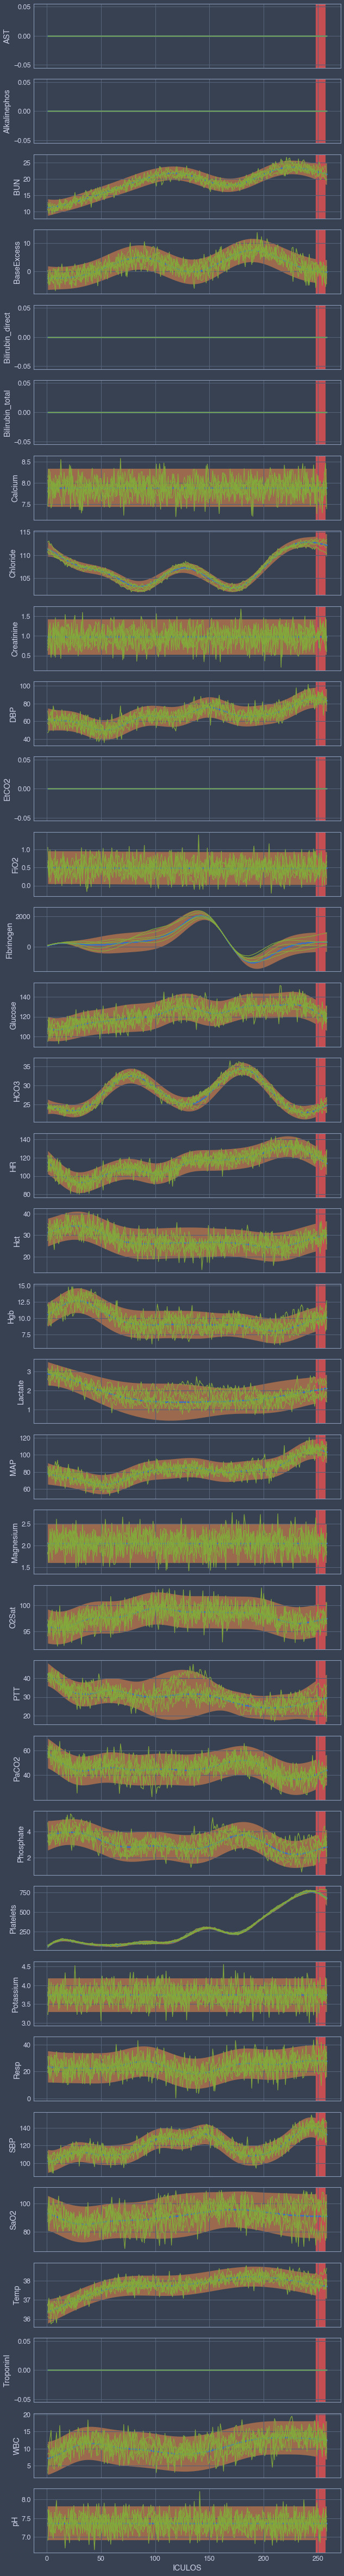

In [137]:
fig, ax = plt.subplots(34, 1, figsize=(9, 66), sharex=True)
for idx, measurement in tqdm(enumerate([key for key in f.keys() \
                                        if 'cov' not in key and \
                                        key not in ['Age', 'Gender', 'Unit1', 'Unit2',
                                                    'ICULOS', 'HospAdmTime', 'SepsisLabel']])):
    ax[idx].plot(
        f['ICULOS'],
        f[measurement],
        'b.'
    )
    std = np.sqrt(np.diag(f[f'{measurement}_cov']))
    ax[idx].fill_between(
        f['ICULOS'],
        f[measurement] - 2 * std,
        f[measurement] + 2 * std,
        alpha=0.5,
        color='y'
    )
    for i in range(5):
        ax[idx].plot(
            f['ICULOS'],
            np.random.multivariate_normal(f[measurement], f['%s_cov' % (measurement)]),
            'g-'
        )
    ax[idx].set_ylabel(measurement)
    ax[idx].axvspan(
        np.where(f['SepsisLabel'][:] == 1)[0][0],
        np.where(f['SepsisLabel'][:] == 1)[0][-1],
        color='r'
    )
plt.xlabel('ICULOS')
plt.tight_layout()

In [363]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258 entries, 0 to 257
Data columns (total 77 columns):
HR                      258 non-null float64
O2Sat                   258 non-null float64
Temp                    258 non-null float64
SBP                     258 non-null float64
MAP                     258 non-null float64
DBP                     258 non-null float64
Resp                    258 non-null float64
EtCO2                   258 non-null int64
BaseExcess              258 non-null float64
HCO3                    258 non-null float64
FiO2                    258 non-null float64
pH                      258 non-null float64
PaCO2                   258 non-null float64
SaO2                    258 non-null float64
AST                     258 non-null int64
BUN                     258 non-null float64
Alkalinephos            258 non-null int64
Calcium                 258 non-null float64
Chloride                258 non-null float64
Creatinine              258 non-null float64
B

In [367]:
df.to_numpy()

array([[1.091040e+02, 9.739625e+01, 3.501818e+01, 1.048776e+02, ..., 9.074059e+01, 2.989861e+01, 0.000000e+00,
        0.000000e+00],
       [1.169995e+02, 9.899940e+01, 3.510917e+01, 1.159992e+02, ..., 4.312120e+01, 1.298995e+01, 0.000000e+00,
        0.000000e+00],
       [1.230939e+02, 1.001760e+02, 3.519948e+01, 1.222523e+02, ..., 1.033323e-02, 4.471763e-01, 0.000000e+00,
        0.000000e+00],
       [1.271167e+02, 1.008977e+02, 3.528907e+01, 1.252548e+02, ..., 1.033324e-02, 4.471504e-01, 0.000000e+00,
        0.000000e+00],
       ...,
       [1.140486e+02, 9.780930e+01, 3.733973e+01, 1.081293e+02, ..., 3.162278e+02, 1.852956e+02, 0.000000e+00,
        0.000000e+00],
       [1.069769e+02, 9.725466e+01, 3.724880e+01, 9.142669e+01, ..., 3.162278e+02, 1.988388e+02, 0.000000e+00,
        0.000000e+00],
       [9.863627e+01, 9.618022e+01, 3.715705e+01, 7.579674e+01, ..., 3.162278e+02, 2.111696e+02, 0.000000e+00,
        0.000000e+00],
       [8.973497e+01, 9.467133e+01, 3.706452e+01, 

In [60]:
df.to_numpy().T.shape

(77, 258)

In [382]:
np.pad(df.to_numpy().T, ((0,0), (336-len(df), 0)))

array([[  0.      ,   0.      ,   0.      ,   0.      , ..., 114.048606, 106.976898,  98.636274,  89.734973],
       [  0.      ,   0.      ,   0.      ,   0.      , ...,  97.809299,  97.25466 ,  96.18022 ,  94.671332],
       [  0.      ,   0.      ,   0.      ,   0.      , ...,  37.339731,  37.248798,  37.157055,  37.06452 ],
       [  0.      ,   0.      ,   0.      ,   0.      , ..., 108.129327,  91.426688,  75.796744,  61.895415],
       ...,
       [  0.      ,   0.      ,   0.      ,   0.      , ..., 316.227766, 316.227766, 316.227766, 316.227766],
       [  0.      ,   0.      ,   0.      ,   0.      , ..., 185.295616, 198.838782, 211.169581, 222.36645 ],
       [  0.      ,   0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,   0.      ,   0.      ]])

In [720]:
# Saving labels
for file in os.listdir('challenge/interpolated/training'):
    if file.lower().endswith('psv'):
        label = pd.read_csv(f'challenge/interpolated/training/{file}', index_col=0)['SepsisLabel']
        label = np.pad(label.to_numpy(), (336-len(df), 0))
        np.savetxt(f'challenge/interpolated/labels/{file}', label, delimiter='|')
        print(file, end='\r')

In [937]:
# Saving best labels
labels = []
for idx, file in enumerate(os.listdir('challenge/interpolated/training')):
    if file.lower().endswith('psv'):
        label = pd.read_csv(f'challenge/interpolated/training/{file}', index_col=0)['SepsisLabel'].to_numpy()
        if np.any(label):
            dt_early   = -12
            dt_optimal = -6
            dt_late    = 3
            t_sepsis   = np.argmax(label) - dt_optimal
            label[max(0, t_sepsis + dt_early) : min(t_sepsis + dt_late + 1, len(label))] = 1
        label = np.pad(label, (336-len(label), 0))
        np.savetxt(f'challenge/interpolated/best_labels/{file}', label, delimiter='|')
        labels.append(label)
        print("[%s/%s] : %s" % (idx, len(os.listdir('challenge/interpolated/training')), file), end='\r')
        
np.save('challenge/interpolated/best_labels/y.npy', labels)

In [960]:
pd.read_csv(f'challenge/interpolated/best_labels/p000001.psv', header=None).to_numpy().squeeze()

array([0., 0., 0., 0., ..., 0., 0., 0., 0.])

In [30]:
# Pickling memmap .dat files
for file in tqdm(os.listdir('challenge/interpolated/training_cov_dat')):
    if file.lower().endswith('dat'):
        f = np.memmap('challenge/interpolated/training_cov_dat/%s' % (file), dtype='float64', mode='r')
        f = f.reshape(f[-3:].astype('int32'))
        f.dump('challenge/interpolated/training_cov_npy/%s.npy' % (file.split('.dat')[0]))

## FastAI data_block API

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import fastai
from fastai.basic_train import *
from fastai.train import *
from fastai.metrics import *
from fastai.callbacks import *
from fastai import core, data_block
from fastai.distributed import *

# torch.multiprocessing.set_start_method('forkserver')
torch.multiprocessing.set_start_method('spawn')
# torch.set_num_threads(24); torch.get_num_threads()

In [9]:
# f = np.memmap('challenge/interpolated/training_cov_npy/p000009.npy', dtype='float64', mode='r')
f = np.load('challenge/interpolated/training_cov_npy/p115810.npy', mmap_mode='c', allow_pickle=True)

In [8]:
class patient_data(core.ItemBase):
    def __init__(self, fn):
#         f = np.memmap(fn, dtype='float64', mode='c')
#         f = f.reshape(f[-3:].astype('int32'))
        f = np.load(fn, allow_pickle=True)
        self.obj = f
        self.len = f.shape[-1]
        self.data = np.vstack((f[:, 0, :], f[:6, -1, :]))
        means, covs = [], []
        self.idxs = []
        self.sepsis = f[6, -1, :]
#         start = time.time()
#         timings = []
        for i, feature in enumerate(f):
            if feature[1:self.len+1, :].any() and len(feature[1:self.len+1, :].shape) == 2:
                self.idxs.append(i)
                means.append(feature[0, :])
                covs.append(feature[1:self.len+1, :])
#         timings.append(time.time()-start)
        self.data = torch.tensor(self.data)
#         timings.append(time.time()-start)
        if len(covs) > 0 and len(means) > 0:
            self.N = torch.distributions.MultivariateNormal(
                torch.tensor(means),
                torch.tensor(covs)
            )
        else:
            self.N = None
#         timings.append(time.time()-start)
#         print(timings)
#         self.data = F.pad(self.data, ((336-self.len), 0))
    def __len__(self):
        return self.len

    def __str__(self):
        return "{} [{}]".format(self.data.shape, self.sepsis.any())
        
    def gaussian_sample(self):
        data = self.data
        if self.N is not None:
            sample = self.N.sample()
            for sample_idx, tensor_idx in enumerate(self.idxs):
#                 data[tensor_idx, 336-self.len:] = sample[sample_idx]
                data[tensor_idx] = sample[sample_idx]
        return data
    
    def apply_tfms(self, tfms, **kwargs):
        self.data = self.gaussian_sample()
        return self

In [38]:
# data = patient_data(np.array(f))
# data = patient_data('challenge/interpolated/training_cov_npy/p115810.npy')
data = patient_data('challenge/interpolated/training_cov_npy/p000009.npy')

In [39]:
data.data

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.1269e+01,  1.1289e+01,  1.1315e+01,  ...,  2.1763e+01,
          2.1677e+01,  2.1592e+01],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-3.0000e-02, -3.0000e-02, -3.0000e-02,  ..., -3.0000e-02,
         -3.0000e-02, -3.0000e-02],
        [ 1.0000e+00,  2.0000e+00,  3.0000e+00,  ...,  2.5600e+02,
          2.5700e+02,  2.5800e+02]], dtype=torch.float64)

In [152]:
data.gaussian_sample().shape

torch.Size([40, 336])

In [84]:
data.data[2][250:], data.gaussian_sample()[2][250:]

(tensor([], dtype=torch.float64), tensor([], dtype=torch.float64))

In [9]:
class data_list(data_block.ItemList):
    def __init__(self, items, *args, **kwargs):
        super().__init__(items, **kwargs)
    
    def get(self, i):
        filename = super().get(i)
#         f = np.memmap(filename, dtype='float64', mode='c')
#         f = f.reshape(f[-3:].astype('int32'))
#         f = np.array(f)
        return patient_data(filename)

    def reconstruct(self, t):
        return

In [10]:
dl = data_list.from_folder('D:/training_cov_npy/')

In [11]:
dl.filter_by_func(lambda fn: fn.suffix == '.npy')

RuntimeError: cholesky: LAPACK library not found in compilation

In [34]:
for idx, x in enumerate(tqdm(dl)):
    try:
        x.gaussian_sample()
    except Exception as e:
        print(idx, e)
        break

KeyboardInterrupt: 

In [202]:
dl.get(0)

patient_GPR_data torch.Size([40, 54]) [False]

In [190]:
dl.get(0).obj.columns[::41]

Index([], dtype='object')

In [184]:
dl.get(0).data[0][300:], dl.get(0).gaussian_sample().data[0][300:]

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [114]:
label_cls = dl.get_label_cls(dl[10].obj['SepsisLabel']); label_cls

fastai.data_block.CategoryList

In [15]:
sd = dl.split_none(); sd

ItemLists;

Train: data_list (40336 items)
torch.Size([40, 54]) [False],torch.Size([40, 23]) [False],torch.Size([40, 48]) [False],torch.Size([40, 29]) [False],torch.Size([40, 48]) [False]
Path: challenge/interpolated/training_cov_npy;

Valid: data_list (0 items)

Path: challenge/interpolated/training_cov_npy;

Test: None

In [12]:
sd = dl.split_by_rand_pct(0.5, seed=42); sd

In [203]:
dl[0].apply_tfms([]).data.shape

torch.Size([40, 336])

In [72]:
torch.from_numpy(np.pad(dl[10].obj['SepsisLabel'].to_numpy(), (336-len(dl[10].obj), 0)))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [20]:
def zero_padder(fn):
    f = np.load(fn, mmap_mode='c', allow_pickle=True)
    l = f.shape[-1]
    sepsis_label = f[6, -1, :]
    sepsis_label = np.pad(sepsis_label, ((336-l), 0), mode='constant')
    print("%s: %s [%d, %s]   " % (fn, sepsis_label, l, sepsis_label.any()), end='\r')
    return sepsis_label

In [21]:
%%time
ll = sd.label_from_func(
    zero_padder,
    classes=range(336),
    label_cls=data_block.MultiCategoryList,
    one_hot=True
); ll

CPU times: user 2min 26s, sys: 45 s, total: 3min 11s [0. 0. 0. 0. ... 0. 0. 0. 0.] [35, False]    
Wall time: 11min 14s


LabelLists;

Train: LabelList (40336 items)
x: data_list
torch.Size([40, 54]) [False],torch.Size([40, 23]) [False],torch.Size([40, 48]) [False],torch.Size([40, 29]) [False],torch.Size([40, 48]) [False]
y: MultiCategoryList
,,,,
Path: challenge/interpolated/training_cov_npy;

Valid: LabelList (0 items)
x: data_list

y: MultiCategoryList

Path: challenge/interpolated/training_cov_npy;

Test: None

In [14]:
with Pool() as p:
    train = iter(tqdm(p.imap(zero_padder, sd.train.items), total=len(sd.train.items)))
    valid = iter(tqdm(p.imap(zero_padder, sd.valid.items), total=len(sd.valid.items)))
    ll = sd.label_from_lists(
        train, valid,
        classes=range(336),
        label_cls=data_block.MultiCategoryList,
        one_hot=True
    )

In [40]:
skf = StratifiedKFold(10, random_state=42)

In [59]:
np.any(ll.y.items, axis=1).astype('int')

1

In [101]:
for train_idx, test_idx in skf.split(range(len(ll.test.x)), np.any(ll.test.y.items, axis=1).astype('int')):
    split_ils = ll.test.x.split_by_idxs(train_idx, test_idx)
    split_ils_y = ll.test.y.split_by_idxs(train_idx, test_idx)
    x_train, x_valid, y_train, y_valid = split_ils.train, split_ils.valid, \
        split_ils_y.train, split_ils_y.valid
    ll.train = data_block.LabelList(x_train, y_train, tfms=[])
    ll.valid = data_block.LabelList(x_valid, y_valid, tfms=[])
    break

In [102]:
ll

LabelLists;

Train: LabelList (36301 items)
x: data_list
torch.Size([40, 8]) [True],torch.Size([40, 56]) [True],torch.Size([40, 34]) [True],torch.Size([40, 43]) [True],torch.Size([40, 118]) [True]
y: MultiCategoryList
328;329;330;331;332;333;334;335,326;327;328;329;330;331;332;333;334;335,326;327;328;329;330;331;332;333;334;335,326;327;328;329;330;331;332;333;334;335,326;327;328;329;330;331;332;333;334;335
Path: challenge/interpolated/training_cov_npy;

Valid: LabelList (4035 items)
x: data_list
torch.Size([40, 54]) [False],torch.Size([40, 23]) [False],torch.Size([40, 48]) [False],torch.Size([40, 29]) [False],torch.Size([40, 48]) [False]
y: MultiCategoryList
,,,,
Path: challenge/interpolated/training_cov_npy;

Test: LabelList (40336 items)
x: data_list
torch.Size([40, 54]) [False],torch.Size([40, 23]) [False],torch.Size([40, 48]) [False],torch.Size([40, 29]) [False],torch.Size([40, 48]) [False]
y: MultiCategoryList
,,,,
Path: challenge/interpolated/training_cov_npy

In [67]:
ll.test = ll.train
ll.train = None
ll

LabelLists;

Train: None;

Valid: LabelList (0 items)
x: data_list

y: MultiCategoryList

Path: challenge/interpolated/training_cov_npy;

Test: LabelList (40336 items)
x: data_list
torch.Size([40, 54]) [False],torch.Size([40, 23]) [False],torch.Size([40, 48]) [False],torch.Size([40, 29]) [False],torch.Size([40, 48]) [False]
y: MultiCategoryList
,,,,
Path: challenge/interpolated/training_cov_npy

In [38]:
ll.y.items

array([[0.0, 0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0, 0.0],
       ...,
       [0.0, 0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0, 0.0]], dtype=object)

In [206]:
ll.x[0].apply_tfms(0).data.shape

torch.Size([40, 336])

In [207]:
ll.x[0].data.shape

torch.Size([40, 336])

In [428]:
np.unique(ll.y.items, return_index=True, return_counts=True)

(array([0, 1], dtype=object), array([   0, 1670]), array([3407550,    8898]))

In [70]:
ll.lists[0].get(6878).obj.columns[41:]

Index([], dtype='object')

In [25]:
dl.items[0]

PosixPath('challenge/interpolated/training_cov/p000001.hdf5')

In [27]:
with Pool() as p:
    def check_cov_dims(path):
        with h5py.File(path, 'r') as f:
            for cov in np.array([f[k][()] for k, v in f.items() if '_cov' in k and v[()].any()]):
#                 tqdm.write("{}: {} [{}]".format(path, cov.shape, len(cov.shape)), end='\r')
                if len(cov.shape) < 2 or cov.shape[0] != cov.shape[-1]:
                    return(path, cov.shape)
                    break
    r = list(tqdm(p.imap(
        check_cov_dims,
        dl.items
    ), total=len(dl.items)))
    print(r)


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, No

In [75]:
for idx, x in enumerate(tqdm(ll.x, desc='Data')):
    with Pool() as p:
        def cov_dims_check(path, cov):
            print(path) if len(cov.shape) < 2 else None
        r = (p.imap(
            partial(cov_dims_check, ll.x.items[idx]),
            [x.obj[k+'_cov'][()] for k, v in x.obj.items() if k in x.MN_cols]
        ), )

KeyboardInterrupt: 

In [100]:
for idx, y in enumerate(ll.y):
    print('%d/%d: %s' % (idx, len(ll.y), y.raw), end='\r')
    if y.raw.max() > 0:
        print(idx)
        break

4


In [22]:
def pad_collate(batch):
    data = torch.stack([F.pad(
        item[0].data,
        ((336-len(item[0])), 0)
    ) for item in batch], dim=0)
    targets = torch.stack([torch.from_numpy(item[1].data) for item in batch], dim=0)
    return [data, targets]

In [50]:
F.pad(datab.x[0].data, (336-len(datab.x[0]), 0)).shape

torch.Size([40, 336])

In [75]:
F.pad(ll.x[0].data, (336-ll.x[0].data.shape[1], 0)).shape

NameError: name 'll' is not defined

In [103]:
datab = ll.transform([]).databunch(
    collate_fn=pad_collate,
    num_workers=1,
#     pin_memory=True,
    bs=1024
); datab

DataBunch;

Train: LabelList (36301 items)
x: data_list
torch.Size([40, 8]) [True],torch.Size([40, 56]) [True],torch.Size([40, 34]) [True],torch.Size([40, 43]) [True],torch.Size([40, 118]) [True]
y: MultiCategoryList
328;329;330;331;332;333;334;335,326;327;328;329;330;331;332;333;334;335,326;327;328;329;330;331;332;333;334;335,326;327;328;329;330;331;332;333;334;335,326;327;328;329;330;331;332;333;334;335
Path: challenge/interpolated/training_cov_npy;

Valid: LabelList (4035 items)
x: data_list
torch.Size([40, 54]) [False],torch.Size([40, 23]) [False],torch.Size([40, 48]) [False],torch.Size([40, 29]) [False],torch.Size([40, 48]) [False]
y: MultiCategoryList
,,,,
Path: challenge/interpolated/training_cov_npy;

Test: LabelList (40336 items)
x: data_list
torch.Size([40, 54]) [False],torch.Size([40, 23]) [False],torch.Size([40, 48]) [False],torch.Size([40, 29]) [False],torch.Size([40, 48]) [False]
y: MultiCategoryList
,,,,
Path: challenge/interpolated/training_cov_npy

In [ ]:
datab.

In [22]:
datab.save('datab.pkl')

In [14]:
%time datab.one_batch()

OSError: [Errno 24] Too many open files

In [12]:
datab = fastai.basic_train.load_data(
    'challenge/interpolated/training_cov_npy',
    'datab.pkl',
    collate_fn=pad_collate,
#     pin_memory=False,
    num_workers=1,
#     timeout=1000000
    bs=1024
)

In [20]:
datab

NameError: name 'f' is not defined

In [109]:
datab.train_ds.x[15331].data

tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [ 14.0000,  14.0000,  14.0000,  ...,  14.0000,  14.0000,  14.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [-16.5800, -16.5800, -16.5800,  ..., -16.5800, -16.5800, -16.5800],
        [  1.0000,   2.0000,   3.0000,  ...,  46.0000,  47.0000,  48.0000]],
       dtype=torch.float64)

In [809]:
%time datab.valid_ds.y[2].data, datab.valid_ds.x[2].data

CPU times: user 14 ms, sys: 5.17 ms, total: 19.2 ms
Wall time: 101 ms


(array([0., 0., 0., 0., ..., 0., 0., 0., 0.], dtype=float32),
 tensor([[  26.3333,   26.3333,   26.3333,  ...,   26.3333,   26.3333,
            26.3333],
         [  70.0000,   70.0000,   70.0000,  ...,   70.0000,   70.0000,
            70.0000],
         [  31.0000,   31.0000,   31.0000,  ...,   31.0000,   31.0000,
            31.0000],
         ...,
         [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
             0.0000],
         [-242.5600, -242.5600, -242.5600,  ..., -242.5600, -242.5600,
          -242.5600],
         [   1.0000,    2.0000,    3.0000,  ...,   40.0000,   41.0000,
            42.0000]], dtype=torch.float64))

In [145]:
%time datab.one_batch(detach=False, denorm=False)

CPU times: user 7.68 s, sys: 1.05 s, total: 8.72 s
Wall time: 34.5 s


(tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  7.7500e+00,
            7.7500e+00,  7.7500e+00],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.0000e-02,
           -3.0000e-02, -3.0000e-02],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  5.7000e+01,
            5.8000e+01,  5.9000e+01]],
 
         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  8.5000e+00,
            8.5000e+00,  8.5000e+00],
          ...,
    

In [807]:
datab.sanity_check()

In [43]:
datab.dls[1].dl.__dict__

{'init_kwargs': {'batch_size': 64,
  'shuffle': False,
  'sampler': None,
  'batch_sampler': None,
  'num_workers': 0,
  'collate_fn': <function torch.utils.data._utils.collate.default_collate(batch)>,
  'pin_memory': True,
  'drop_last': False,
  'timeout': 0,
  'worker_init_fn': None},
 'dataset': LabelList (20168 items)
 x: data_list
 torch.Size([40, 26]) [False],torch.Size([40, 21]) [False],torch.Size([40, 42]) [False],torch.Size([40, 45]) [False],torch.Size([40, 43]) [False]
 y: MultiCategoryList
 ,,,,
 Path: challenge/interpolated/training_cov_npy,
 'num_workers': 0,
 'pin_memory': True,
 'timeout': 0,
 'worker_init_fn': None,
 '_DataLoader__multiprocessing_context': None,
 'dataset_kind': 0,
 'batch_size': 64,
 'drop_last': False,
 'sampler': <torch.utils.data.sampler.SequentialSampler at 0x123a44898>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x123a44860>,
 'collate_fn': <function __main__.pad_collate(batch)>,
 '_DataLoader__initialized': True}

In [49]:
datab.valid_ds.get(0)

patient_data torch.Size([40, 26]) [False]

In [72]:
datab.valid_ds.items[11465]

PosixPath('challenge/interpolated/training_cov_npy/p115810.npy')

In [71]:
datab.valid_ds[11465].__dict__

ValueError: covariance_matrix must be at least two-dimensional, with optional leading batch dimensions

In [53]:
for idx, data in enumerate(tqdm(datab.valid_ds)):
    try:
        data[0].apply_tfms([])
    except Exception as e:
        print(idx, str(e), type(e))

ValueError: covariance_matrix must be at least two-dimensional, with optional leading batch dimensions

In [73]:
for idx, fn in enumerate(tqdm(os.listdir('challenge/interpolated/training'))):
    try:
        if fn.endswith('psv'):
            df = pd.read_csv(f'challenge/interpolated/training/{fn}', index_col=0)
            if len(df.columns) != 75:
                print(idx, fn)
                break
    except Exception as e:
        print(str(e), idx)

13778 p013777.psv


In [ ]:
class Sepsis_Dataset(torch.utils.data.Dataset):
    def __init__(self, )

## Protomodel

In [13]:
from TCN.TCN.tcn import TemporalConvNet, TCN_DimensionalityReduced, TemporalSkipBlock

In [14]:
class TCN_DimensionalityReduced(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2, use_skip_connections=False, reduce_dimensionality=True):
        super(TCN_DimensionalityReduced, self).__init__()
        self.use_skip_connections = use_skip_connections
        layers = []
        num_levels = len(num_channels)
        self.reduce_dimensionality = reduce_dimensionality
        if self.reduce_dimensionality:
            self.d_reduce = nn.Conv1d(num_inputs, num_channels[0], kernel_size=1)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_channels[i-1] if (self.reduce_dimensionality or i!=0) else num_inputs
            out_channels = num_channels[i]
            layers += [TemporalSkipBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                         padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.float()
        if self.use_skip_connections:
            for tb in [m for m in self.network.modules()][2].children():
                skips = [layer for layer in tb.children()][-1]
                self.network(x).add_(skips)
        if self.reduce_dimensionality:
            x = self.d_reduce(x)
        return self.network(x)

In [15]:
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout, **kwargs):
        super(TCN, self).__init__()
        self.tcn = TCN_DimensionalityReduced(input_size,
                                             num_channels,
                                             kernel_size=kernel_size,
                                             dropout=dropout,
                                             **kwargs)
        self.output = nn.Linear(num_channels[-1], 1)
        self.init_weights()

    def init_weights(self):
        self.output.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)
        o = self.output(y1.transpose(1, 2)).squeeze()
        return o

In [16]:
net = TCN(
    40,
    336,
    [32] * 3,
    64,
    0.2,
    use_skip_connections=True,
    reduce_dimensionality=False
)

In [17]:
# torch.set_num_threads(24); torch.set_num_interop_threads(12)
torch.get_num_threads(), torch.get_num_interop_threads()

(1, 12)

In [18]:
learn = Learner(
    data=datab,
    model=net,
    loss_func=nn.BCEWithLogitsLoss(),
    path='prototyping',
    callback_fns=[
        ShowGraph
    ],
)
learn.fit(1, callbacks=[
#     fastai.callbacks.TerminateOnNaNCallback(),
#     fastai.callbacks.SaveModelCallback(
#         learn, every='improvement', monitor='loss', name='proto'
#     )
],)

KeyboardInterrupt: 

In [40]:
learn = Learner(
    data=datab,
    model=TCN(
        40,
        336,
        [32] * 3,
        64,
        0.2,
        use_skip_connections=True,
        reduce_dimensionality=False
    ),
    loss_func=nn.BCEWithLogitsLoss(),
    path='prototyping',
    callback_fns=[
        fastai.callbacks.CSVLogger,
        ShowGraph
    ],
).to_parallel()
learn.fit_one_cycle(cyc_len=50, max_lr=3.8e-3, wd=1e-4, callbacks=[
        TerminateOnNaNCallback(),
        SaveModelCallback(
            learn, every='improvement', monitor='valid_loss', name='ProtoTCN_cov'
        )
    ])

ValueError: covariance_matrix must be at least two-dimensional, with optional leading batch dimensions

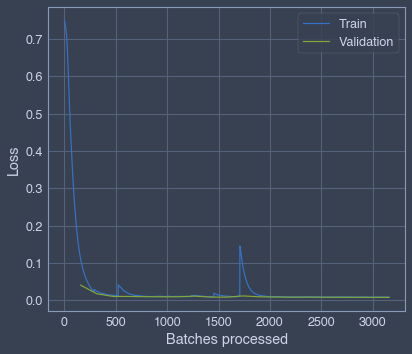

In [98]:
learn.recorder.plot_losses()

In [100]:
torch.save(learn.model.state_dict(), 'challenge/prototyping/proto_cov_TCN.pth')

In [101]:
# preds, y, losses = get_preds(net, datab.valid_dl, loss_func=nn.BCEWithLogitsLoss())
preds, y, losses = get_preds(learn.model, datab.valid_dl, loss_func=nn.BCEWithLogitsLoss())

In [ ]:
pred_attempts = []
for i in tqdm(range(20)):
    preds, y, losses = get_preds(
        learn.model,
        datab.valid_dl,
        loss_func=nn.BCEWithLogitsLoss()
    )
    pred_attempts.append(preds)

In [236]:
pred_attempts = [tensor.numpy() for tensor in pred_attempts]
pred_attempts = np.array(pred_attempts)

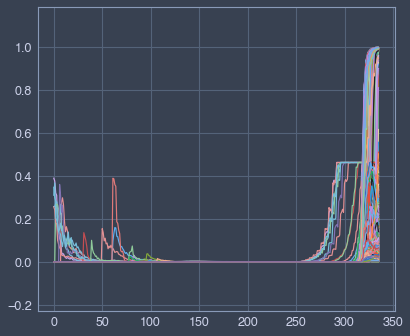

In [267]:
means = nn.Sigmoid()(torch.from_numpy(pred_attempts)).mean(axis=0)
stds  = nn.Sigmoid()(torch.from_numpy(pred_attempts)).std(axis=0)
for idx, pred in enumerate(tqdm(means)):
    plt.plot(pred)
    plt.fill_between(
        range(len(pred)),
        pred - 2*stds[idx],
        pred + 2*stds[idx],
        alpha=3e-6,
        color='chartreuse'
    )
plt.show()

In [105]:
preds.shape

torch.Size([20168, 336])

In [110]:
hist2d = np.histogram2d(
    np.array([[i for i in range(336)] for x in range(10168)]).flatten(),
    means.numpy().flatten(),
    bins=[336, 10]
)

ValueError: The dimension of bins must be equal to the dimension of the  sample x.

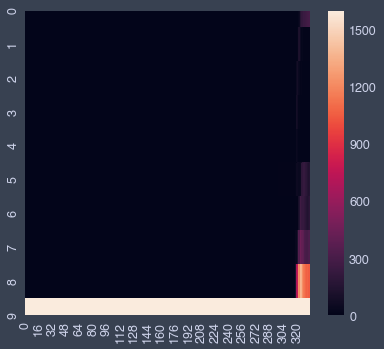

In [317]:
sns.heatmap(
    hist2d[0].T[::-1],
    vmax=1600,
)

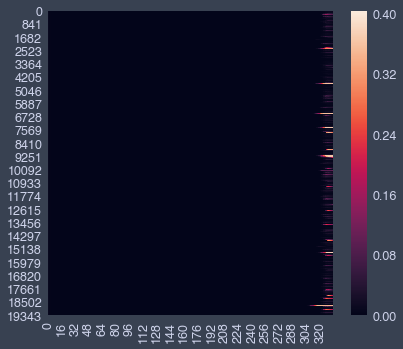

In [117]:
sns.heatmap(nn.Sigmoid()(preds))

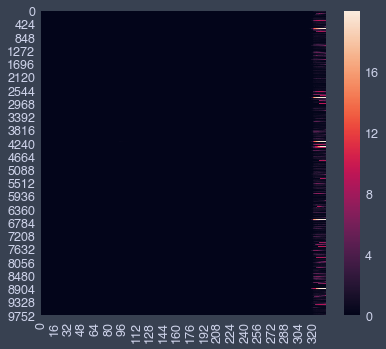

In [321]:
sns.heatmap(nn.Sigmoid()(torch.from_numpy(pred_attempts)).sum(axis=0))

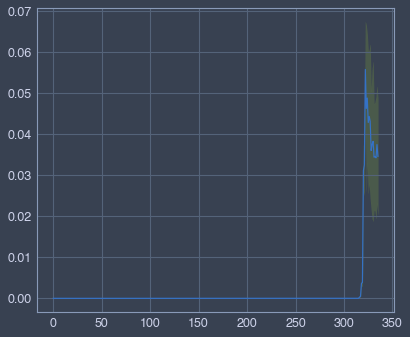

In [271]:
plt.fill_between(
    range(len(means[0])),
    means[0] - 2*stds[0],
    means[0] + 2*stds[0],
    alpha=0.25,
    color='g'
)
plt.plot(means[0], 'b-')

In [118]:
np.histogram(nn.Sigmoid()(preds).flatten(), bins=[1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1])

(array([ 85617, 138777,  87884,  42726,  15103,   9012]),
 array([0.001, 0.003, 0.01 , 0.03 , 0.1  , 0.3  , 1.   ]))

In [119]:
thresh = 1e-1
ppv, pos, neg, fnr = 0, 0, 0, 0
for idx, sepsis_l in enumerate(y):
    output = nn.Sigmoid()(preds[idx])
    if (sepsis_l > 0).any():
        pos += 1
        ppv += bool((output > thresh).any())
        print(idx, bool((output > thresh).any()), sep='\t')
    else:
        neg += 1
        fnr += bool((output > thresh).any())
print("PPV:", ppv/pos)
print("FPR:", fnr/neg)

6	False
16	True
24	True
46	False
73	False
74	False
93	True
112	True
119	True
141	True
174	False
177	True
193	False
197	True
205	True
225	True
233	False
234	False
268	True
283	True
284	True
300	True
303	False
327	True
331	False
335	True
351	True
356	True
363	False
367	True
371	True
375	False
484	True
490	False
510	False
519	True
553	True
558	True
559	True
576	False
593	True
649	False
665	True
696	False
699	True
710	True
727	False
737	True
742	True
765	True
800	True
804	True
852	False
879	True
895	False
897	True
901	True
912	False
918	True
952	True
978	False
987	True
1050	True
1057	True
1062	False
1063	True
1113	True
1115	True
1172	False
1175	True
1186	False
1222	False
1223	False
1226	False
1227	False
1262	True
1265	True
1293	True
1300	False
1308	True
1312	True
1336	True
1342	False
1344	True
1350	True
1360	True
1365	False
1373	True
1382	True
1436	True
1465	False
1484	False
1485	True
1487	False
1498	True
1534	True
1542	False
1547	True
1560	False
1568	True
1571	True
1586	False
1618	True
16

12478	False
12479	False
12493	True
12509	True
12513	False
12522	True
12529	False
12547	True
12635	True
12662	True
12683	True
12706	True
12731	False
12733	True
12739	True
12813	False
12820	False
12826	True
12879	True
12891	False
12900	True
12926	True
12936	True
12944	False
12945	True
12950	True
12968	True
12969	False
12997	True
13002	False
13011	False
13013	False
13045	True
13046	False
13067	True
13071	True
13072	False
13076	True
13115	True
13119	False
13121	True
13143	True
13151	False
13164	True
13170	True
13173	True
13180	True
13191	True
13233	False
13253	True
13254	True
13271	False
13276	True
13304	True
13320	True
13337	True
13341	True
13365	True
13407	True
13420	False
13438	True
13442	False
13464	True
13468	True
13473	True
13481	True
13486	True
13489	True
13501	True
13502	True
13524	False
13534	True
13565	True
13566	True
13579	False
13582	True
13597	False
13598	False
13622	False
13635	True
13636	True
13639	True
13640	True
13645	True
13647	False
13655	True
13670	True
13694	True
13710

In [278]:
idx=1888
print(
    preds[idx][300:],
    nn.Sigmoid()(preds[idx][300:]),
    (nn.Sigmoid()(preds[idx][300:]) > thresh).to(torch.int),
    y[idx][300:],
    losses[idx][300:],
    sep='\n'
)

tensor([-76.8019, -76.2475, -72.6743, -72.0946, -67.5991, -66.9682, -63.0486,
        -62.3977, -57.6582, -56.9787, -52.9358, -52.2509, -47.4303, -46.7231,
        -42.6978, -42.0074, -37.3295, -36.6427, -32.8758, -32.2344, -27.9941,
        -27.5884, -25.9377, -25.6642,  -0.3958,  -0.3564,  -0.1662,  -0.1507,
         -0.1507,  -0.1507,  -0.1507,  -0.1507,  -0.1507,  -0.1507,  -0.1507,
         -0.1507])
tensor([4.4194e-34, 7.6935e-34, 2.7412e-32, 4.8945e-32, 4.3862e-30, 8.2431e-30,
        4.1529e-28, 7.9622e-28, 9.1066e-26, 1.7967e-25, 1.0240e-23, 2.0312e-23,
        2.5193e-21, 5.1100e-21, 2.8613e-19, 5.7071e-19, 6.1375e-17, 1.2197e-16,
        5.2751e-15, 1.0018e-14, 6.9551e-13, 1.0436e-12, 5.4372e-12, 7.1479e-12,
        4.0232e-01, 4.1182e-01, 4.5855e-01, 4.6239e-01, 4.6239e-01, 4.6239e-01,
        4.6239e-01, 4.6239e-01, 4.6239e-01, 4.6239e-01, 4.6239e-01, 4.6239e-01])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1

In [221]:
np.where((nn.Sigmoid()(preds[idx]) > thresh).to(torch.int).numpy() == 1)[0] - 336 + df['ICULOS'].iloc[-1] + 1

array([4, 5, 6, 7, 8, 9])

In [222]:
df[df['SepsisLabel'] == 1]['ICULOS']

2      6
3      7
4      8
5      9
6     10
7     11
8     12
9     13
10    14
Name: ICULOS, dtype: int64

In [203]:
df[df['SepsisLabel'] == 1].iloc[0].name, df[df['SepsisLabel'] == 1].iloc[-1].name

(4, 12)

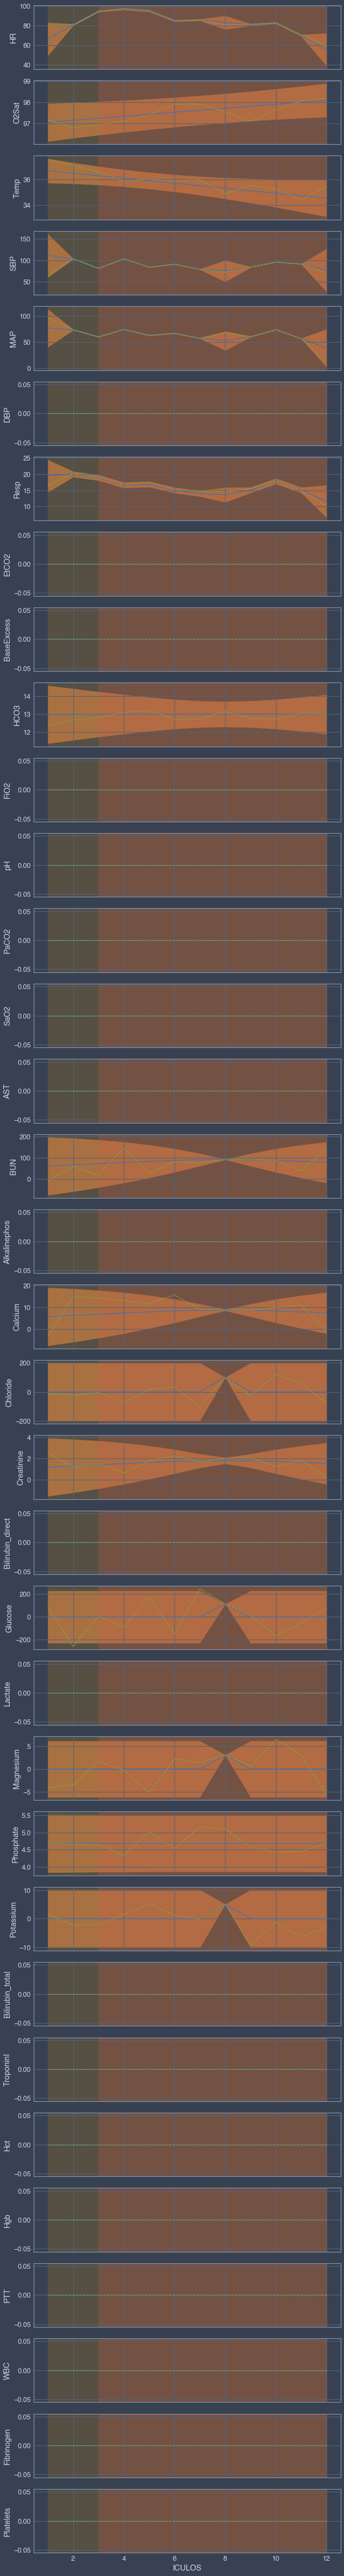

In [279]:
fig, ax = plt.subplots(34, 1, figsize=(9, 66), sharex=True)
df = datab.valid_ds.x.get(idx).obj
for i, measurement in enumerate(tqdm(df.columns[:34])):
    ax[i].plot(df['ICULOS'], df[measurement], 'b-')
    if i < 34:
        ax[i].fill_between(
            df['ICULOS'],
            df[measurement] - 2 * df[f'{measurement}_std'],
            df[measurement] + 2 * df[f'{measurement}_std'],
            alpha=0.5,
            color='y'
        )
        ax[i].plot(
            df['ICULOS'],
            np.random.normal(df[measurement], df['%s_std' % (measurement)], len(df)),
            'g--'
        )
    ax[i].set_ylabel(measurement)
    ax[i].axvspan(
        df[df['SepsisLabel'] == 1]['ICULOS'].iloc[0],
        df[df['SepsisLabel'] == 1]['ICULOS'].iloc[-1],
        color='r',
        alpha=0.25
    )
    ax[i].axvspan(
        np.where(
            (nn.Sigmoid()(preds[idx]) > thresh).to(torch.int).numpy() == 1
        )[0][0] - 336 + df['ICULOS'].iloc[-1] + 1,
        np.where(
            (nn.Sigmoid()(preds[idx]) > thresh).to(torch.int).numpy() == 1
        )[0][-1] - 336 + df['ICULOS'].iloc[-1] + 1,
        color='orange',
        alpha=0.15
    )
plt.xlabel('ICULOS')
plt.tight_layout()

In [120]:
print(sklearn.metrics.classification_report(
    np.any(y.numpy(), axis=1),
    np.any((nn.Sigmoid()(preds).numpy() > thresh), axis=1),
    labels=[False, True]
))

              precision    recall  f1-score   support

       False       0.97      0.92      0.94     18696
        True       0.39      0.65      0.49      1472

    accuracy                           0.90     20168
   macro avg       0.68      0.79      0.72     20168
weighted avg       0.93      0.90      0.91     20168



In [143]:
# auroc, auprc, accuracy, f_measure, normalized_observed_utility
%time get_normalised_utility_score( \
    y.numpy(), \
    (nn.Sigmoid()(preds).numpy() > thresh).astype('int'), \
    nn.Sigmoid()(preds).numpy() \
)

CPU times: user 5min 23s, sys: 568 ms, total: 5min 24s
Wall time: 5min 24s


(0.9932856845944348,
 0.3640571979646942,
 0.9967308832001662,
 0.41878525514889153,
 0.4963481659870647)